<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [15]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [16]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [17]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [18]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [19]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 200

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [20]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.06 seconds


Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

and finally, plot the results side-by-side

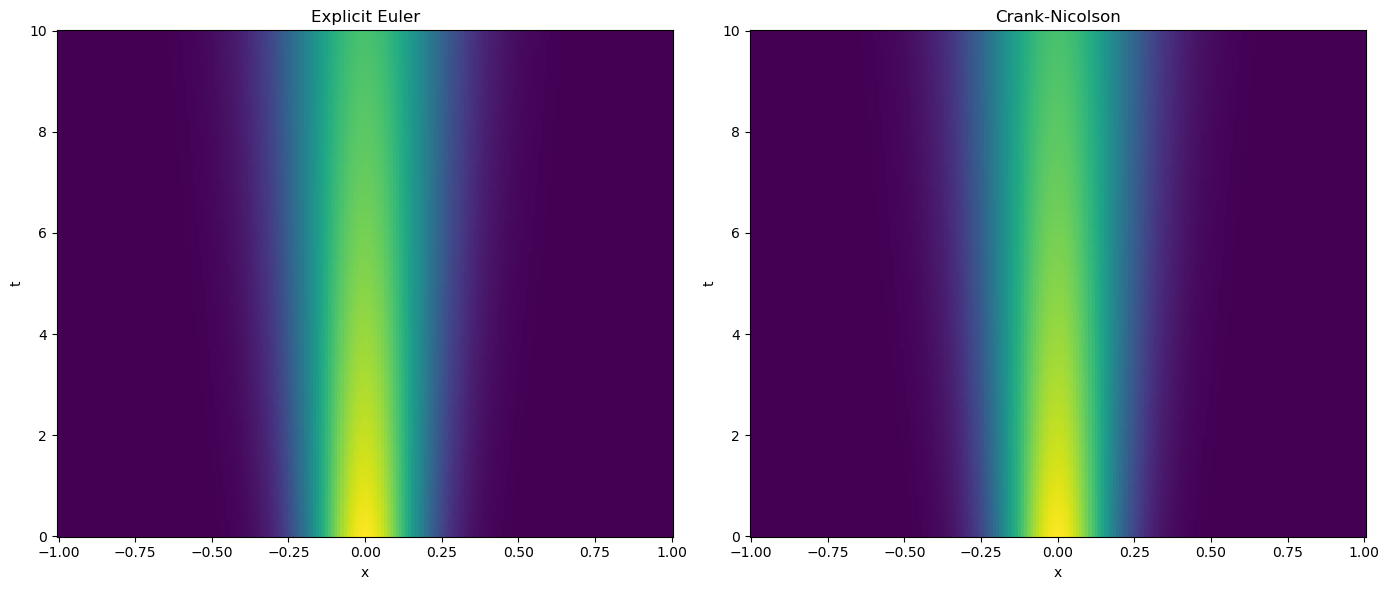

In [21]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')


plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and/or increase the diffusivity ($\kappa$) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

Nx changes the resolution of the simulation.
At very low and very high resolutions, explicit Euler degrades and becomes unstable. 
Crank-Nicolson remains stable at all values of Nx.

Similarly, at high values of kappa, once again explicit euler becomes unstable, while Crank-Nicolson remains stable.

Changing the timestep shows the same result, with Euler becoming unstable beyond `Nt` < 190

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

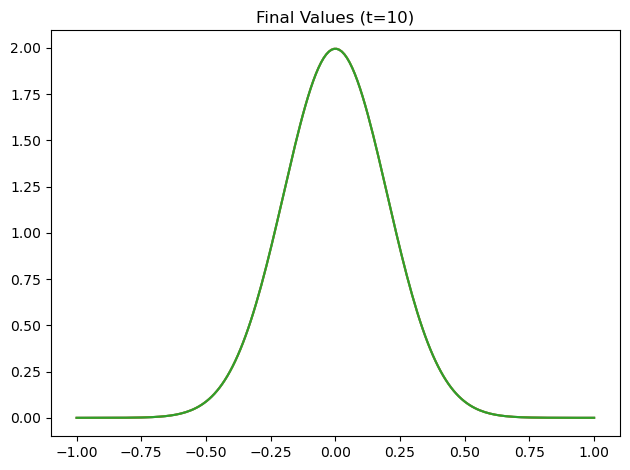

In [22]:
def explicit(x, t):
    return np.sqrt(1 / (4*np.pi*kappa*t))* np.exp((-(x**2)) / (4*kappa*t))

plt.plot(x, c_EE[:, -1])
plt.plot(x, c_CN[:, -1])
plt.plot(x, explicit(x, 20))
plt.title('Final Values (t=10)')
plt.tight_layout()

plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

I have defined the error as the "sum of the absolute differences across the grid, divided by the number of gridpoints"

Final Error in EE: 3.0160311654544232e-05
Final Error in CN: 7.359311248601799e-05


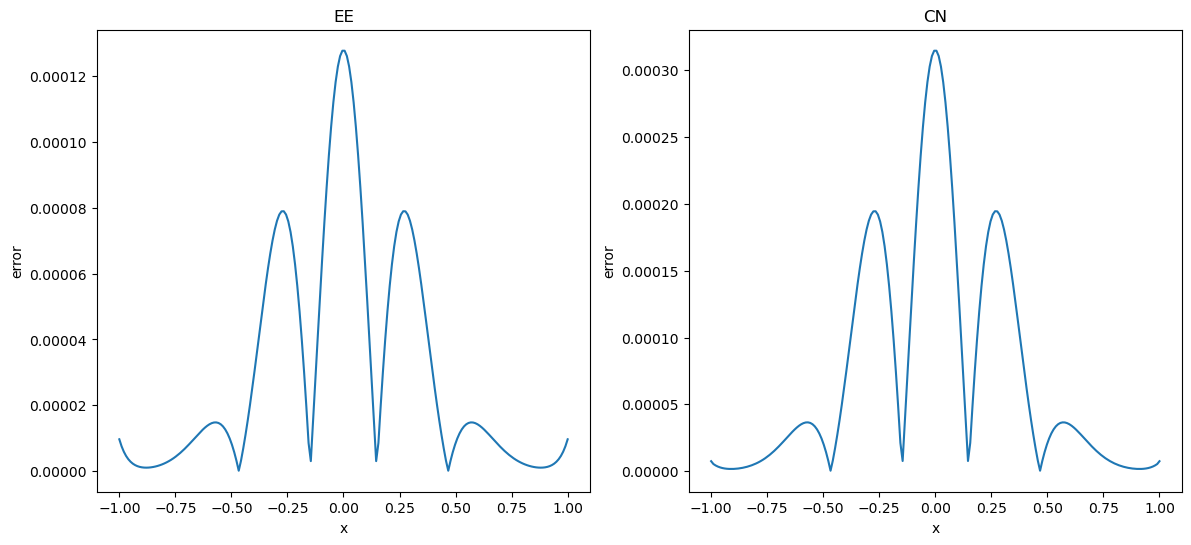

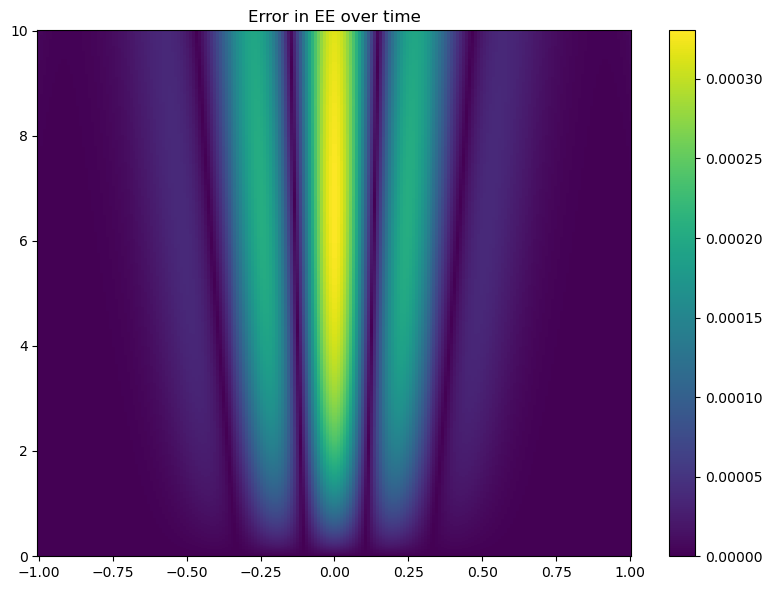

In [23]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
error_in_EE = np.abs(c_EE[:, -1] - explicit(x, 20))
error_value_in_EE = np.sum(error_in_EE)/Nx
plt.plot(x, error_in_EE)
plt.title("EE")
plt.xlabel('x')
plt.ylabel('error')
print(f"Final Error in EE: {error_value_in_EE}")


plt.subplot(1, 2, 2)
error_in_CN = np.abs(c_CN[:, -1] - explicit(x, 20))
error_value_in_CN = np.sum(error_in_CN)/Nx
plt.plot(x, error_in_CN)
plt.title("CN")
plt.xlabel('x')
plt.ylabel('error')
print(f"Final Error in CN: {error_value_in_CN}")

#plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))

t2 = t+10
X, T = np.meshgrid(x, t2)
plt.pcolormesh(x, t, np.abs(c_CN.T - explicit(X, T)), shading='auto')
plt.colorbar()#orientation="horizontal")
plt.title('Error in EE over time')
plt.tight_layout()
plt.show()



Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.02 seconds


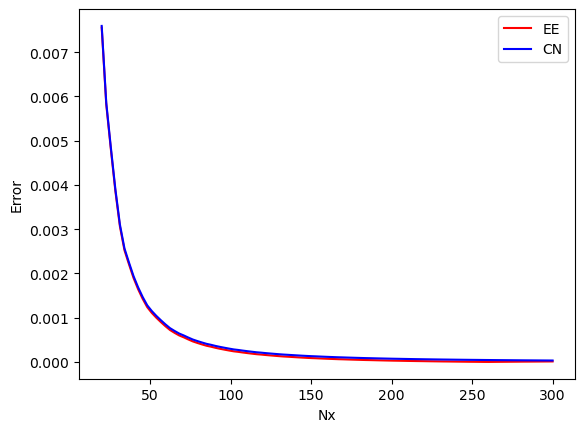

In [ ]:
nx_range = np.linspace(20, 250, 100)
ee_errors = np.empty_like(nx_range)
cn_errors = np.empty_like(nx_range)

for i, nx in enumerate(nx_range):
    x_new = np.linspace(x_start, x_end, int(nx))
    c_EE = EE(x_new, t, kappa)
    c_CN = CN(x_new, t, kappa)
    ee_errors[i] = np.sum(np.abs(c_EE[:, -1] - explicit(x_new, 20)))/nx
    cn_errors[i] = np.sum(np.abs(c_CN[:, -1] - explicit(x_new, 20)))/nx

plt.plot(nx_range, ee_errors, color='red', label="EE")
plt.plot(nx_range, cn_errors, color='blue', label="CN")
plt.xlabel("Nx")
plt.ylabel("Error")
plt.legend()
plt.show()

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.01 seconds


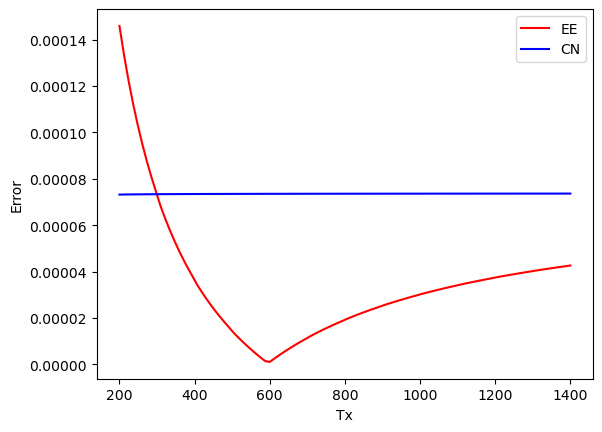

In [12]:
tx_range = np.linspace(200, 1400, 100)
ee_errors = np.empty_like(tx_range)
cn_errors = np.empty_like(tx_range)

for i, tx in enumerate(tx_range):
    t_new = np.linspace(t_start, t_end, int(tx))
    c_EE = EE(x, t_new, kappa)
    c_CN = CN(x, t_new, kappa)
    ee_errors[i] = np.sum(np.abs(c_EE[:, -1] - explicit(x, 20)))/Nx
    cn_errors[i] = np.sum(np.abs(c_CN[:, -1] - explicit(x, 20)))/Nx

plt.plot(tx_range, ee_errors, color='red', label="EE")
plt.plot(tx_range, cn_errors, color='blue', label="CN")
plt.xlabel("Tx")
plt.ylabel("Error")
plt.legend()
plt.show()
    

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

<span style="color:#E95E5EFF">

explicit Euler has a lower error at higher temporal resolution, and consistently has a lower error for all spatial resolutions
explicit Euler is also consistently faster (0.03 seconds compared to 0.08 seconds) than Crank-Nicolson, and therefore is faster at finding low error solutions.
However, the error for CN at high spatial resolutions is similar to EE, and CN is considerably more stable to wider temporal/spatial ranges. Therefore, while explicit euler is faster, Crank-Nicolson is a good alternative when wide ranges of time/space are being considered, as its error is still considearbly less than 1e-4 and therefore is acceptable in most cases

The error being zero at Tx = 600 is due to a sign flip of the absolute difference values. There is still significant error but the different sources of error happen to cancel each other out at this position.

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?